## Notes

- In de laatste cell is het plotten de limiterende factor

## Check/To do

- Is de code nu inderdaad wel een 6-body problem of niet? Bij 10^4 objecten duurt 1 stap al ~10 tellen
- Velocity kick
- Maak V_orbit vs a_orbit plot tijdens simulatie en check of objecten die V_esc overschrijden ook daadwerkelijk escapen

In [1]:
#Here we import all the necessary dependencies
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from IPython.display import clear_output
from amuse.lab import units, constants
from amuse.ext.orbital_elements import new_binary_from_orbital_elements
from amuse.ext.orbital_elements import get_orbital_elements_from_binary
from amuse.lab import Particles
from amuse.lab import nbody_system
from amuse.couple import bridge
from amuse.lab import Rebound
from amuse.lab import Mercury
from amuse.community.ph4.interface import ph4

In [2]:
def random_positions_and_velocities(N_objects, sun_loc):
    positions = np.zeros((N_objects, 3)) | units.AU
    velocities = np.zeros((N_objects,3)) | units.kms
    
    m_sun = 1 | units.MSun
    m_oort = 0 | units.MSun
    for i in range(N_objects):
        a = np.random.uniform(4, 40) | units.AU
        e = np.random.uniform(0, 0.05)
        inclination = np.random.uniform(-5, 5) | units.deg
        true_anomaly = np.random.uniform (0, 360) | units.deg
        arg_of_periapsis = np.random.uniform(0, 360) | units.deg
        long_of_ascending_node = np.random.uniform(0, 360) | units.deg
        sun_and_oort = new_binary_from_orbital_elements(m_sun, m_oort, 
                                          a, e, true_anomaly, inclination, long_of_ascending_node, arg_of_periapsis, G=constants.G)
        positions[i] = (sun_and_oort[1].x+sun_loc[0]), (sun_and_oort[1].y+sun_loc[1]), (sun_and_oort[1].z+sun_loc[2])
        velocities[i]= sun_and_oort[1].vx, sun_and_oort[1].vy, sun_and_oort[1].vz
    return positions, velocities

In [3]:
#Here we generate a basic solarsystem, with only the gas giants
from amuse.ext.solarsystem import new_solar_system

def create_system():
    
    system = new_solar_system()
    system = system[system.mass > 10**-5 | units.MSun]
    system.move_to_center()
    return system
    
    
basic_giants_system = create_system()

|S11


In [4]:
#Define the number of Oort objects and create random velocities and positions
N_objects = 10**2
sun_loc = [basic_giants_system[0].x.in_(units.AU), basic_giants_system[0].y.in_(units.AU), basic_giants_system[0].z.in_(units.AU)]
positions, velocities = random_positions_and_velocities(N_objects, sun_loc)

In [5]:
#Here we add the Oort cloud objects, according to a chosen distribution
def add_comet_objects(system, N_objects, rand_pos, rand_vel):
    
    for i in tqdm(range(N_objects)):
        oort = Particles(1)
        oort.name = "OORT_" + str(i)
        oort.mass = 0.0 | units.MSun
        oort.position = (rand_pos[i, 0], rand_pos[i, 1], rand_pos[i, 2])
        oort.velocity = (rand_vel[i, 0], rand_vel[i, 1], rand_vel[i, 2])

        system.add_particle(oort)
    return system

complete_system = add_comet_objects(basic_giants_system, N_objects, positions, velocities)

100%|██████████| 100/100 [00:00<00:00, 573.31it/s]


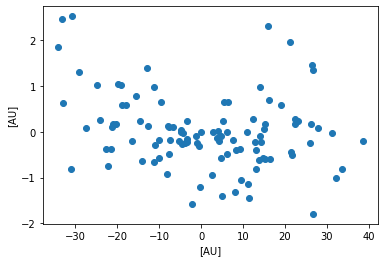

In [6]:
#plot the distribution in the orbital plane
import amuse.plot as plot
plot.scatter(complete_system.x, complete_system.z)

In [7]:
#Here we generate a galactic potential 

class MilkyWay_galaxy(object):
    def __init__(self, 
                 Mb=1.40592e10| units.MSun,
                 Md=8.5608e10| units.MSun,
                 Mh=1.07068e11 | units.MSun):
        self.Mb= Mb
        self.Md= Md
        self.Mh= Mh

    def get_potential_at_point(self,eps,x,y,z):
        r=(x**2+y**2+z**2)**0.5
        R= (x**2+y**2)**0.5
        # buldge
        b1= 0.3873 |units.kpc
        pot_bulge= -constants.G*self.Mb/(r**2+b1**2)**0.5 
        # disk
        a2= 5.31 |units.kpc
        b2= 0.25 |units.kpc
        pot_disk = -constants.G*self.Md/(R**2 + (a2+ (z**2+ b2**2)**0.5 )**2 )**0.5
        #halo
        a3= 12.0 |units.kpc
        cut_off=100 |units.kpc
        d1= r/a3
        c=1+ (cut_off/a3)**1.02
        pot_halo= -constants.G*(self.Mh/a3)*d1**1.02/(1+ d1**1.02) \
                  - (constants.G*self.Mh/(1.02*a3))\
                      * (-1.02/c +numpy.log(c) + 1.02/(1+d1**1.02) \
                           - numpy.log(1.0 +d1**1.02) )
        return 2*(pot_bulge+pot_disk+ pot_halo) 
                # multiply by 2 because it is a rigid potential
    
    def get_gravity_at_point(self, eps, x,y,z): 
        r= (x**2+y**2+z**2)**0.5
        R= (x**2+y**2)**0.5
        #bulge
        b1= 0.3873 |units.kpc
        force_bulge= -constants.G*self.Mb/(r**2+b1**2)**1.5 
        #disk
        a2= 5.31 |units.kpc
        b2= 0.25 |units.kpc
        d= a2+ (z**2+ b2**2)**0.5
        force_disk=-constants.G*self.Md/(R**2+ d**2 )**1.5
        #halo
        a3= 12.0 |units.kpc
        d1= r/a3
        force_halo= -constants.G*self.Mh*d1**0.02/(a3**2*(1+d1**1.02))
       
        ax= force_bulge*x + force_disk*x  + force_halo*x/r
        ay= force_bulge*y + force_disk*y  + force_halo*y/r
        az= force_bulge*z + force_disk*d*z/(z**2 + b2**2)**0.5 + force_halo*z/r 

        return ax,ay,az
    
MW_potential = MilkyWay_galaxy()

In [8]:
#Here we create the conditions for the migration of the planets

def planet_migration():
    
    #velocities = 
    return velocities

final_system = complete_system#.add(velocities)
final_system.move_to_center()

In [9]:
#Here we perform the conversion for the system
converter_length = get_orbital_elements_from_binary(final_system[0:2], G = constants.G)[2].in_(units.AU)
final_converter=nbody_system.nbody_to_si(final_system.mass.sum(), 
                                   converter_length)

In [28]:
#Here we evolve the basic system, without grandtack or Milky way potential
if N_objects > 2*10**3:
    gravity_code = Mercury(final_converter)
else:
    gravity_code = ph4(final_converter)
  
    

def vanilla_evolver(particle_system, converter, gravity_code, N_objects, end_time=4*10**3, time_step=0.1):
    names = ['Sun', 'Jupiter', 'Saturn', 'Uranus', 'Neptune']
    
    gravity_code.particles.add_particles(particle_system)
    ch_g2l = gravity_code.particles.new_channel_to(particle_system)
    
    times = np.arange(0., end_time, time_step) | units.day
    for t in tqdm(times):
        if np.array(abs(gravity_code.particles.x)).any() > 50 | units.AU or np.array(abs(gravity_code.particles.y)).any() > 50 | units.AU or np.array(abs(gravity_code.particles.z)).any() > 50 | units.AU:
            print('Ja', t)
        gravity_code.evolve_model(t)
        ch_g2l.copy()
        
        if t == (end_time-time_step) | units.day:
            plot.scatter(gravity_code.particles.x.in_(units.AU), gravity_code.particles.y.in_(units.AU), s= 6)
            # Plotting an AU around Jupiter to see if objects are captured
            #plot.xlim(gravity_code.particles[1].x -  (1 | units.AU), gravity_code.particles[1].x + (1 | units.AU))
            #plot.ylim(gravity_code.particles[1].y -  (1 | units.AU), gravity_code.particles[1].y + (1 | units.AU))
            for i in range(5):
                plot.scatter(gravity_code.particles[i].x.in_(units.AU), gravity_code.particles[i].y.in_(units.AU), label = names[i])
            plot.text(-35, 32, "Time = " + str(t.value_in(units.yr))[0:7] + " yrs.")
            plt.legend()
            fig = plt.gcf()
            fig.set_size_inches(12, 9)
            clear_output(wait=True) 
            plt.show()
        
    gravity_code.stop()
    return particle_system
    
    
    
#vanilla_evolved_system = vanilla_evolver(final_system, final_converter, N_objects, end_time= 10**5, time_step= 50)

Exception: MPI_ERR_SPAWN: could not spawn processes

In [11]:
def MWG_evolver(particle_system, converter, N_objects, end_time=4*10**3, time_step=0.1):
    names = ['Sun', 'Jupiter', 'Saturn', 'Uranus', 'Neptune']
    
    if N_objects > 2*10**3:
        gravity_code = Mercury(converter)
    else:
        gravity_code = ph4(converter)
    gravity_code.particles.add_particles(particle_system)
    ch_g2l = gravity_code.particles.new_channel_to(particle_system)
    
    gravity_bridge = 0
    gravity_bridge = bridge.Bridge(use_threading=False)
    gravity_bridge.add_system(gravity_code, (potential,) )
    gravity_bridge.timestep = time_step|units.day
    
    times = np.arange(0., end_time, time_step) | units.day
    for t in tqdm(times):
        gravity_code.evolve_model(t)
        ch_g2l.copy()
        
        if t == (end_time-time_step) | units.day:
            plot.scatter(gravity_bridge.particles.x.in_(units.AU), gravity_bridge.particles.z.in_(units.AU), s= 6)
            # Plotting an AU around Jupiter to see if objects are captured
            #plot.xlim(gravity_bridge.particles[1].x -  (1 | units.AU), gravity_bridge.particles[1].x + (1 | units.AU))
            #plot.ylim(gravity_bridge.particles[1].y -  (1 | units.AU), gravity_bridge.particles[1].y + (1 | units.AU))
            for i in range(5):
                plot.scatter(gravity_bridge.particles[i].x.in_(units.AU), gravity_bridge.particles[i].z.in_(units.AU), label = names[i])
            plt.legend()
            fig = plt.gcf()
            fig.set_size_inches(12, 9)
            clear_output(wait=True) 
            plt.show()
        
    gravity_code.stop()
    
    
    
#MWG_evolved_system = MWG_evolver(final_system, final_converter, N_objects, end_time= 10**5, time_step= 50)

In [12]:
#For 10**2 objects with no plotting, no mass change, no collisions, ph4 and MWG, about 50 it/s (tend = 10**5, timestep = 50)

#For 10**2 objects with no plotting, no mass change, no collisions, ph4 and no MWG, about 250 it/s (tend = 10**5, timestep = 50)
#For 10**3 objects with no plotting, no mass change, no collisions, ph4 and no MWG, about 15-20 it/s (tend = 10**5, timestep = 50)
#For 10**4 objects with no plotting, no mass change, no collisions, ph4 and no MWG, about 1/15 it/s (tend = 10**5, timestep = 50)

#For 10**2 objects with no plotting, no mass change, no collisions, Mercury and no MWG, about 65 it/s (tend = 10**5, timestep = 50)
#For 10**3 objects with no plotting, no mass change, no collisions, Mercury and no MWG, about 13 it/s (tend = 10**5, timestep = 50)
#For 10**4 objects with no plotting, no mass change, no collisions, Mercury and no MWG, about 1/2.5 it/s (tend = 10**5, timestep = 50)